Smoothening:
- Gaussian/Median blur
- Bilateal filter

Sharpening?

Detection:
- Canny edge
- Line detect
- Derivative detect
- Binary + contour
- Corner detect

Area of interest?

In [1]:
### Import library
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks
from scipy.stats import linregress
import math
import pwlf # piecewise linear fit
import sklearn # scikit learn: linear fit and clustering
from sklearn.cluster import DBSCAN, OPTICS # clustering options
from sklearn.mixture import GaussianMixture # clustering options
import img_processing

Image size is  (2048, 2048, 3)


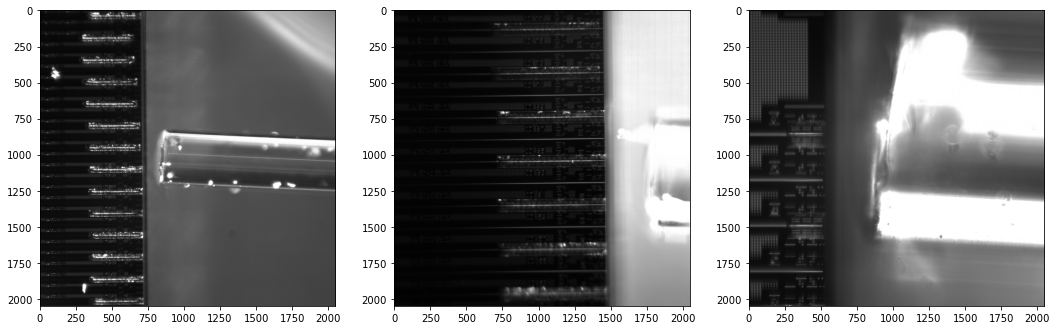

In [2]:
### Show image
img10 = cv.imread('Photos/Photo_Fiber_Obj_10X.tif')
img20 = cv.imread('Photos/Photo_Fiber_Obj_20X.tif')
img50 = cv.imread('Photos/Photo_Fiber_Obj_50X.tif')
print("Image size is ", img10.shape)
plt.figure(figsize=[18,6])
plt.subplot(131); plt.imshow(img10)
plt.subplot(132); plt.imshow(img20)
plt.subplot(133); plt.imshow(img50)

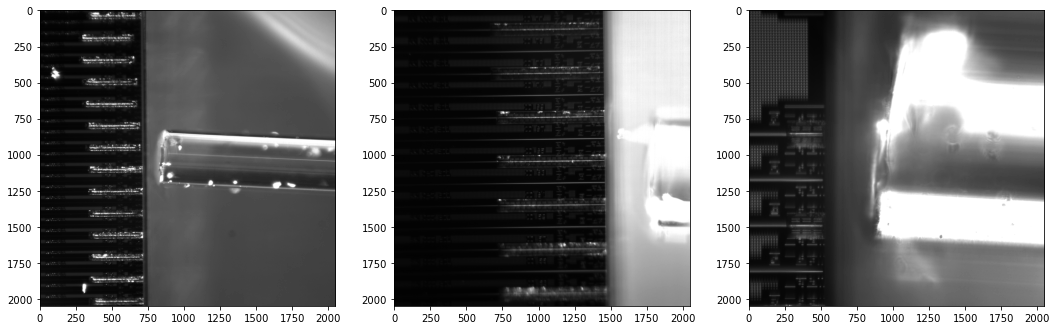

In [3]:
### Gray conversion
imgs = [img10, img20, img50]
grays = []
hsv = []
plt.figure(figsize=[18,6])
for i in range(0,3):
    grays.append(cv.cvtColor(imgs[i], cv.COLOR_BGR2GRAY))
    hsv.append(cv.cvtColor(imgs[i], cv.COLOR_BGR2HSV))
    plt.subplot(131+i)
    plt.imshow(grays[i], cmap='gray')

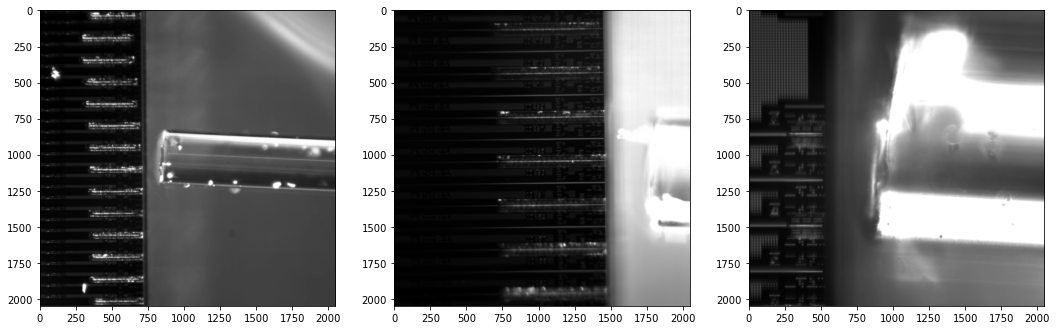

In [4]:
### Smoothening
# compare between Median blur and Gaussian blur
# identify noise patch? further cleaning?

plt.figure(figsize=[18,6])
blurs = []
for i in range(0,3):
    blurs.append(cv.GaussianBlur(grays[i],(0,0),2)) 
    # (0,0): Gaussian kernel size. ksize.width and ksize.height can differ but 
    # they both must be positive and odd. Or, they can be zero's and then they are computed from sigma.
    # 2: pixel extrapolation
#     blurs.append(cv.GaussianBlur(grays[i],(7,7),11))
#     blurs.append(cv.medianBlur(grays[i],51))
    plt.subplot(131+i)
    plt.imshow(blurs[i], cmap='gray')


[   0.          731.38545335  750.26225587 2047.        ]
[   0.         1432.91702797 1567.34824145 2047.        ]
[   0.          584.56219526 1118.66876669 2047.        ]


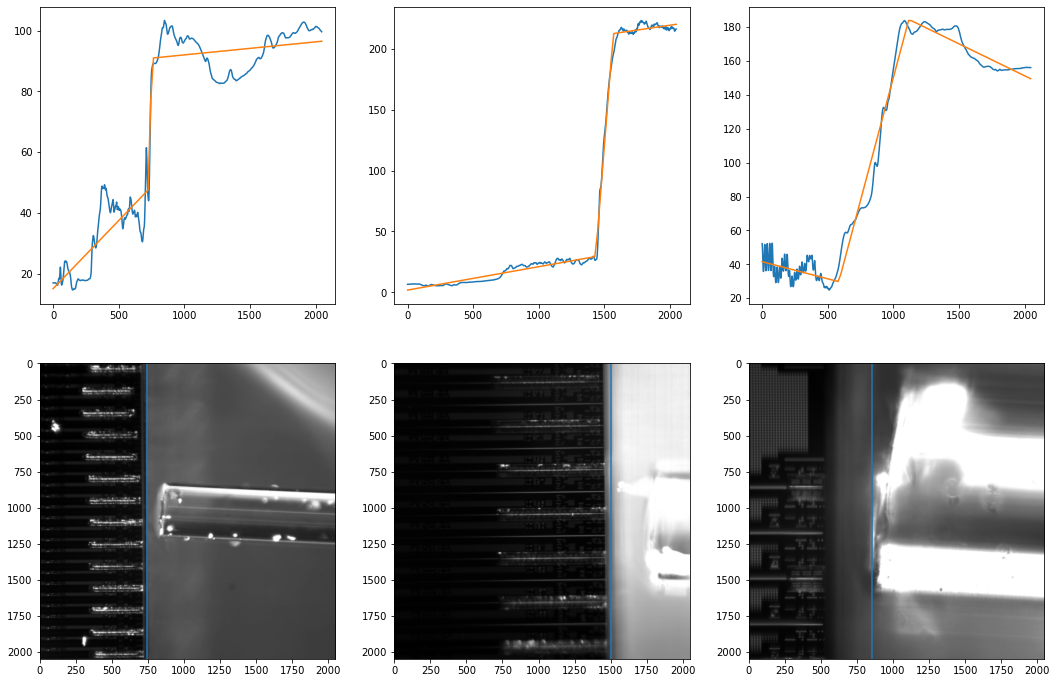

In [6]:
### Image segmentation into chip and fiber
### Auto-segmentation vs manual-segmentation?

plt.figure(figsize=[18,12])
segs = []
    
for i in range(0,3):
    plt.subplot(231+i)
    x = np.arange(0,blurs[i].shape[1]) # width (horizontal) of the image
    y = np.array(list(np.mean(blurs[i][:,j]) for j in range(0,blurs[i].shape[1]))) # todo
    plt.plot(x, y)

    my_pwlf = pwlf.PiecewiseLinFit(x, y)
    segs.append(my_pwlf.fit(3)) # 3 is the number of segments
    x_hat = np.linspace(x.min(), x.max(), 100) # to plot the orange line
    y_hat = my_pwlf.predict(x_hat)
    plt.plot(x_hat, y_hat, '-')
    print(segs[i])

for i in range(0,3):
    plt.subplot(234+i)
    plt.imshow(blurs[i], cmap='gray')
    plt.axvline(x = int((segs[i][1] + segs[i][2])/2))

plt.show()

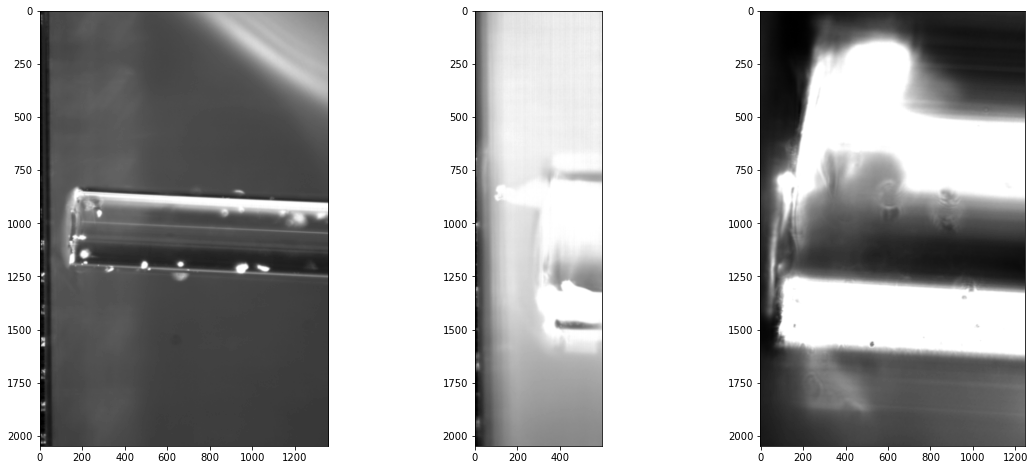

In [7]:
f = []
plt.figure(figsize=[18,8])
for i in range(0,3):
    f.append(img_separator(blurs[i])[1])
    plt.subplot(131+i)
    plt.imshow(f[i], cmap='gray')

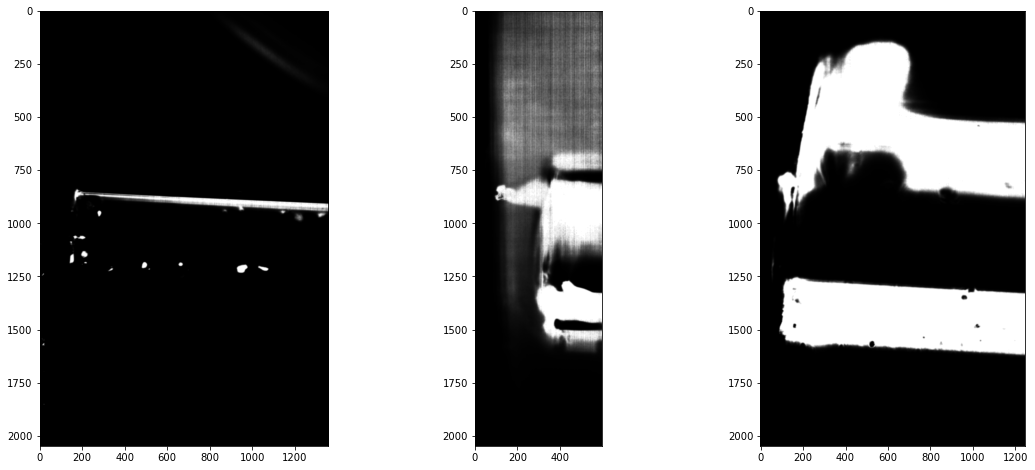

In [8]:
### Contrast enhancer
### 2 methods: alpha*image + beta or gamma power

alpha = 1.4
beta = -100

# When γ<1, the original dark regions will be brighter and 
# the histogram will be shifted to the right whereas it will be the opposite with γ>1.
gamma = 14
# gamma = 0.5
plt.figure(figsize=[18,8])
lookUpTable = np.empty((1,256), np.uint8)

for i in range(256):
    lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)

pf = []
for i in range(0,3):
    image = f[i]
    
    new_image = cv.LUT(image, lookUpTable) # LUT is look up table
#     new_image = np.clip(alpha*image + beta, 0, 255)
    
    pf.append(new_image)
    plt.subplot(131+i)
    plt.imshow(pf[i], cmap='gray')

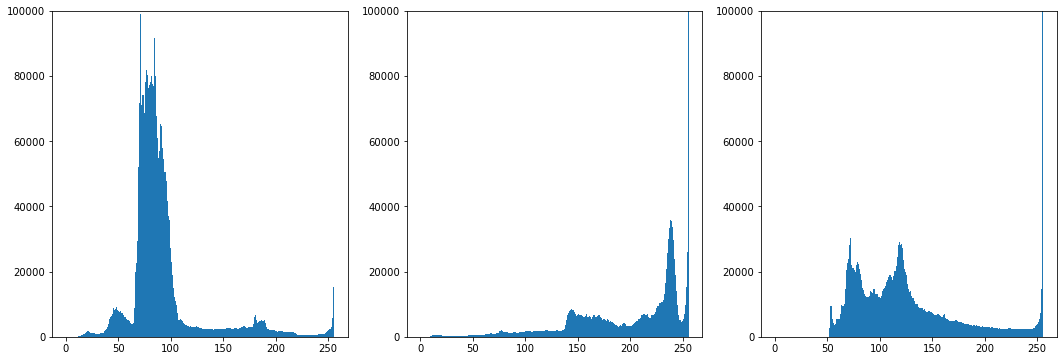

In [11]:
### Image histogram
plt.figure(figsize=[18,6])
for i in range(0,3):
    plt.subplot(131+i)
    plt.hist(f[i].ravel(),256,[0,256])
    plt.ylim([0,1e5])
plt.show()

41 124
111 255
66 198


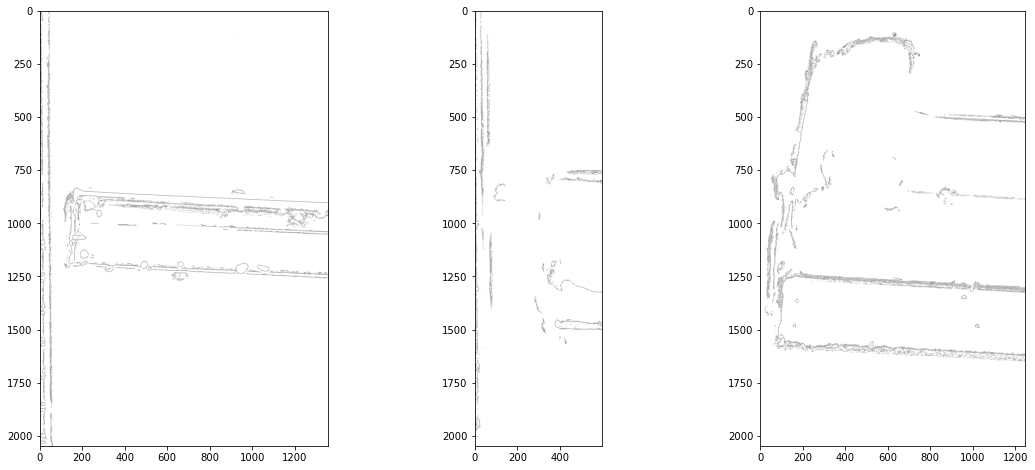

In [99]:
### Canny edge
# apply optimal Canny edge detection using the computed median

y_pos = 1000
plt.figure(figsize=[18,8])
cannys = []
for i in range(0,3):
    v = np.median(f[i])
    sigma = 0.5
    lower_thresh = int(max(0, (1.0 - sigma) * v))
    upper_thresh = int(min(255, (1.0 + sigma) * v))
    print(lower_thresh,upper_thresh)
    cannys.append(cv.Canny(f[i], 10, 20))
    plt.subplot(131+i)
    plt.imshow(cv.bitwise_not(cannys[i]), cmap='gray')
#     plt.axhline(y=y_pos)
#     plt.subplot(234+i)
#     peaks, properties = find_peaks(cannys[i][pos,:], prominence=15)
#     plt.plot(peaks, cannys[i][pos,:][peaks], "x", c="red")
#     plt.plot(range(0,cannys[i].shape[1]), cannys[i][y_pos,:], label='Canny edge')
#     plt.plot(range(0,f[i].shape[1]), f[i][y_pos,:], label='Orginal')
#     plt.xlim([0,2048])
#     plt.legend()
    

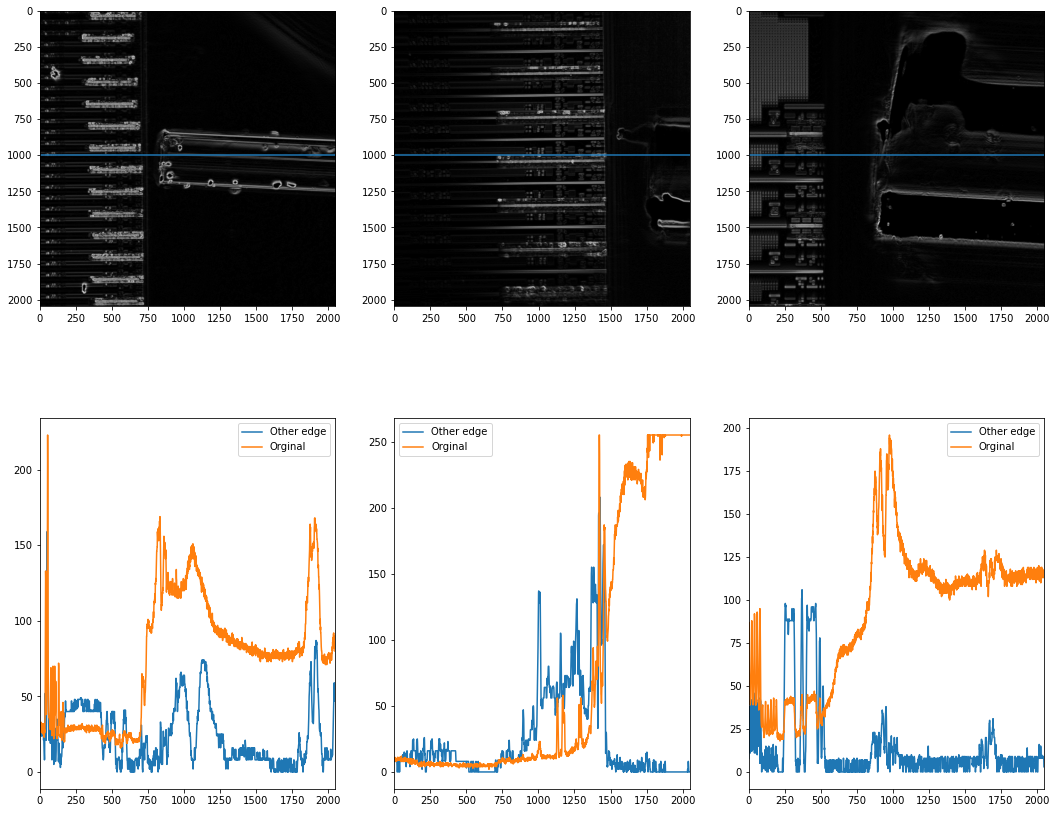

In [727]:
### Other edge detection methods
scale = 1
delta = 0
ddepth = cv.CV_16S
plt.figure(figsize=[18,15])
others = []
for i in range(0,3):
    grad_x = cv.Sobel(blurs[i], ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    # Gradient-Y
    grad_y = cv.Scharr(blurs[i],ddepth,0,1)
#     grad_y = cv.Sobel(blurs[i], ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    
    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)
    
    
    grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    others.append(grad)
    plt.subplot(231+i)
    plt.imshow(others[i], cmap='gray')
    plt.axhline(y=y_pos)
    plt.subplot(234+i)
#     peaks, properties = find_peaks(cannys[i][pos,:], prominence=15)
#     plt.plot(peaks, cannys[i][pos,:][peaks], "x", c="red")
    plt.plot(range(0,others[i].shape[1]), others[i][y_pos,:], label='Other edge')
    plt.plot(range(0,grays[i].shape[1]), grays[i][y_pos,:], label='Orginal')
    plt.xlim([0,2048])
    plt.legend()

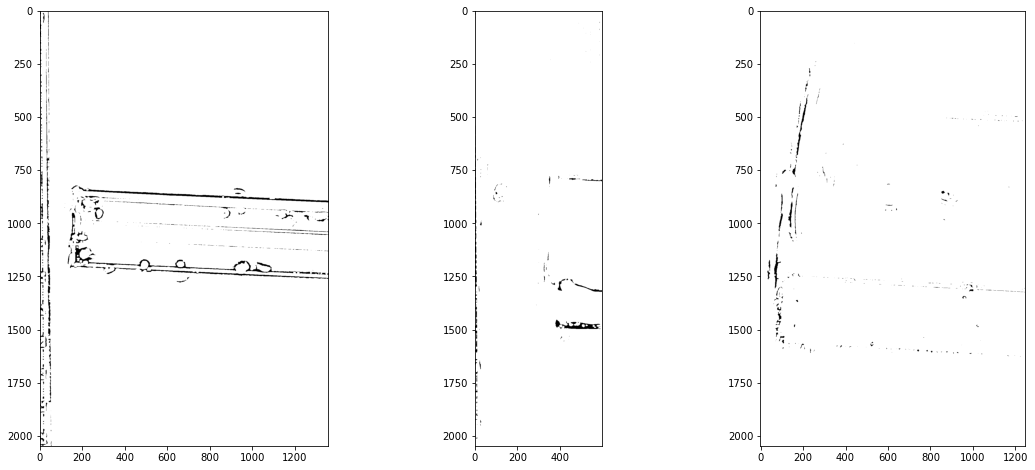

In [151]:
### Adaptive binary

y_pos = 1000
adaps = []
for i in range(0,3):
    adaps.append(cv.bitwise_not(cv.adaptiveThreshold(f[i],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv.THRESH_BINARY,21,2)))

plt.figure(figsize=[18,8])
for i in range(0,3):
    plt.subplot(131+i)
    erode = cv.erode(adaps[i], np.ones((3,3)), iterations=2)
    plt.imshow(cv.bitwise_not(erode), cmap='gray')
#     plt.axhline(y=y_pos)
#     plt.subplot(234+i)
#     peaks, properties = find_peaks(cannys[i][pos,:], prominence=15)
#     plt.plot(peaks, cannys[i][pos,:][peaks], "x", c="red")
#     plt.plot(range(0,adaps[i].shape[1]), adaps[i][y_pos,:], label='Adaptive threshold')
#     plt.plot(range(0,f[i].shape[1]), f[i][y_pos,:], label='Orginal')
#     plt.xlim([0,2048])
#     plt.legend()


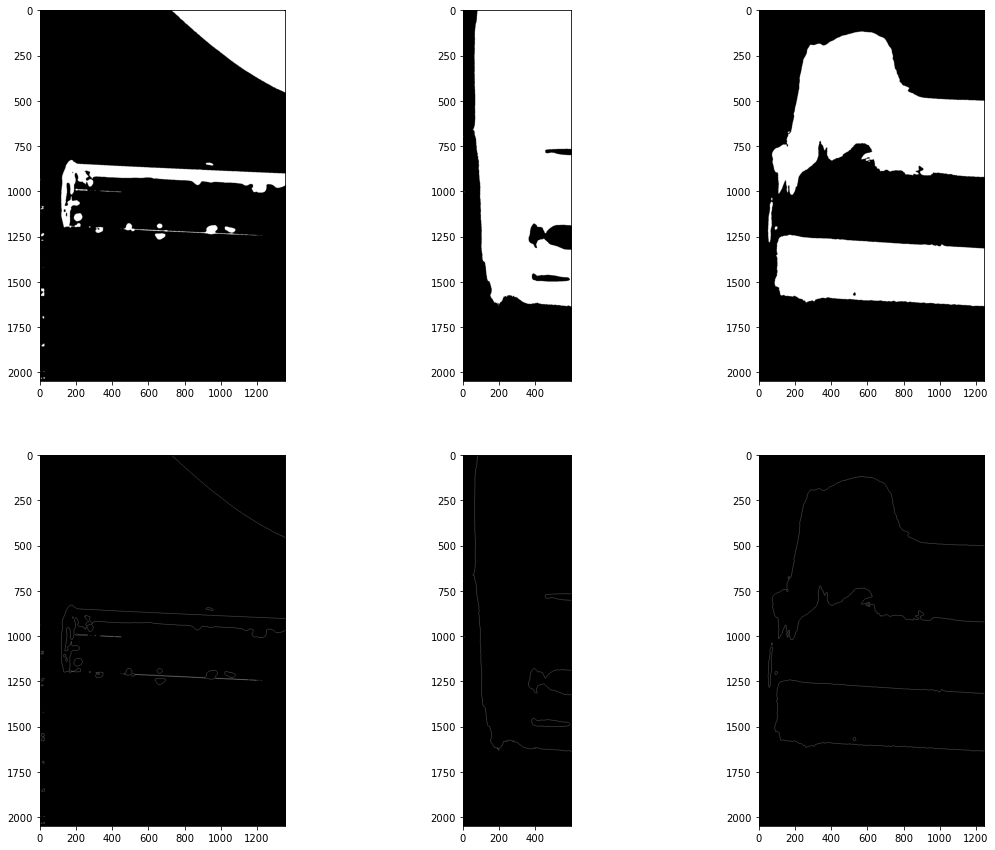

In [114]:
### Basic binary and contour
### Otsu will determine the threshold automatically.

y_pos = 1000

otsu = []
for i in range(0,3):
    otsu.append(cv.threshold(f[i], 127, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1])
    
plt.figure(figsize=[18,15])
blanks = []
for i in range(0,3):
    plt.subplot(231+i)
    plt.imshow(otsu[i], cmap='gray')

    blank = np.zeros(otsu[i].shape, dtype = 'uint8') # black blank image
    contours, hierarchies = cv.findContours(otsu[i], cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE) # find contour of binary images
    cv.drawContours(blank, contours, -1, (255,255,255), 1)
    blanks.append(blank)
#     print(len(contours))
    plt.subplot(234+i)
    plt.imshow(blank, cmap='gray')


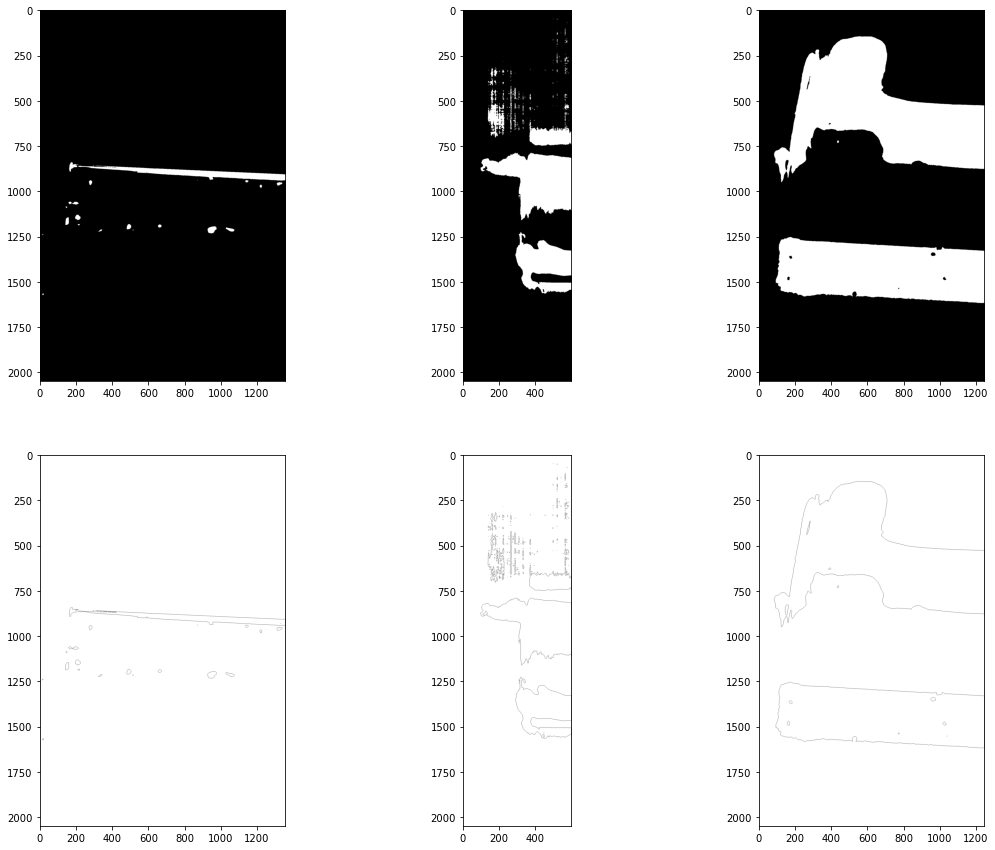

In [9]:
### Basic binary and contour
### Otsu will determine the threshold automatically.
### To apply method on contrast enhanced images.

y_pos = 1000

potsu = []
for i in range(0,3):
    potsu.append(cv.threshold(pf[i], 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1])
    
plt.figure(figsize=[18,15])
pblanks = []
for i in range(0,3):
    plt.subplot(231+i)
    plt.imshow(potsu[i], cmap='gray')

    blank = np.zeros(potsu[i].shape, dtype = 'uint8')
    contours, hierarchies = cv.findContours(potsu[i], cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(blank, contours, -1, (255,255,255), 1)
    pblanks.append(blank)
#     print(len(contours))
    plt.subplot(234+i)
    plt.imshow(cv.bitwise_not(blank), cmap='gray')


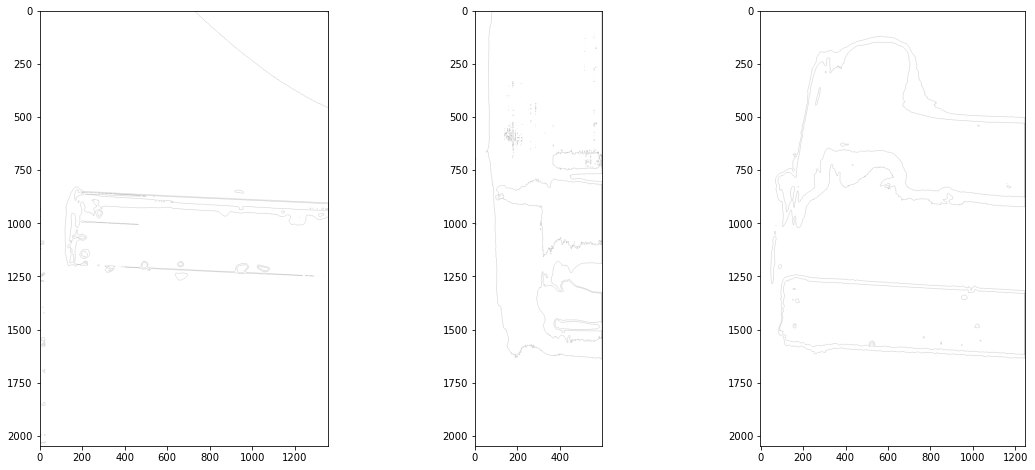

In [57]:
### Comparison of contours of between original and contrast enhanced images
plt.figure(figsize=[18,8])
for i in range(0,3):
    plt.subplot(131+i)
    new_img = cv.addWeighted(blanks[i], 0.5, pblanks[i], 0.5, 0.0)
    plt.imshow(cv.bitwise_not(new_img), cmap='gray')


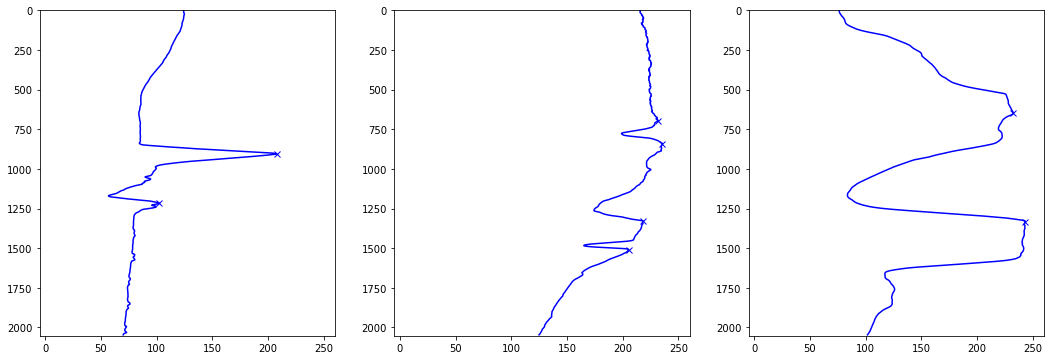

[array([ 904, 1217]), array([ 695,  842, 1330, 1509]), array([ 645, 1332])]


In [7]:
### Vertical profiling to calculate the background grayscale intensity
plt.figure(figsize=[18,6])

peaks = []
for i in range(0,3):
    plt.subplot(131+i)
    y = np.arange(0,f[i].shape[0])
    x = np.array(list(np.mean(f[i][j,:]) for j in range(0,f[i].shape[0])))
    plt.plot(x, y, c='blue')
    plt.xlim([-5,260])
    plt.ylim([-5,2053])
    plt.gca().invert_yaxis()
    peaks.append(find_peaks(x, prominence=15)[0])
    plt.plot(x[peaks[i]], peaks[i], "x", c="blue")
# for i in range(0,3):
#     plt.subplot(131+i)
#     y = np.arange(0,pf[i].shape[0])
#     x = np.array(list(np.mean(pf[i][j,:]) for j in range(0,pf[i].shape[0])))
#     plt.plot(x, y, c='red')
#     plt.xlim([-5,260])
#     plt.ylim([-5,2053])
#     plt.gca().invert_yaxis()
#     peaks, properties = find_peaks(x, prominence=20)
#     plt.plot(x[peaks], peaks, "x", c="red")
plt.show()
print(peaks)

In [12]:
### Background and fiber area grayscale median
for i in range(0,3):
    first_peak = peaks[i][0]
    last_peak = peaks[i][len(peaks[i])-1]
    # margin of 50 pixels
    background= np.concatenate((f[i][:first_peak-50,:].ravel(),f[i][last_peak+50:,:].ravel()))
    bg_median = np.median(background)
    fiber_median = np.median(f[i][first_peak+50:last_peak-50,:].ravel())
    print(first_peak, last_peak, bg_median, fiber_median)

904 1217 82.0 84.0
695 1509 207.0 225.0
645 1332 124.0 130.0


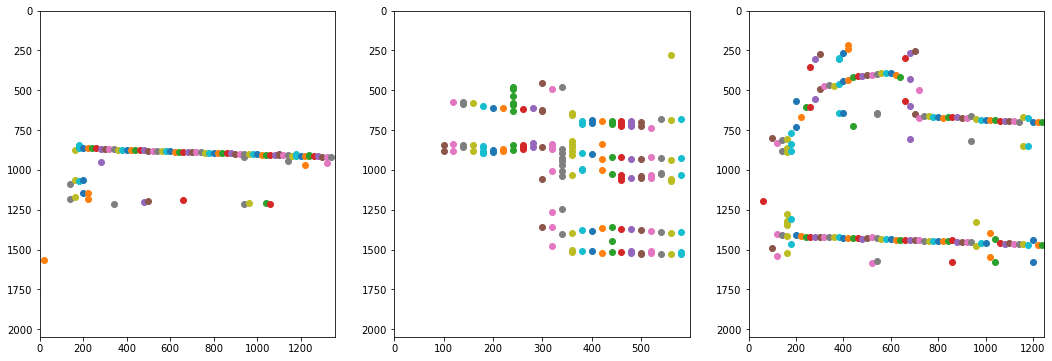

In [28]:
### Get peaks  by sampling to obtain straight lines to calculate the angle 
plt.figure(figsize=[18,6])

step = 20
data = []
for i in range(0,3):
    plt.subplot(131+i)
    x_data = []
    y_data = []
    for j in range(0,pf[i].shape[1],step):
#         if j < abs(step):
#             break
#         y = np.arange(0,pf[i].shape[0])
#         x = np.array(list(np.mean(pf[i][k,j+step:j]) for k in np.arange(0,pf[i].shape[0])))
        x = pf[i][:,j]
        peaks, _ = find_peaks(x, prominence=50)
#         plt.scatter([j+step/2]*len(peaks), peaks)
#         x_data.append([j+step/2]*len(peaks))
        plt.scatter([j]*len(peaks), peaks)
        x_data.append([j]*len(peaks))
        y_data.append(peaks)
#         print(peaks)
        plt.ylim([0,pf[i].shape[0]])
        plt.xlim([0,pf[i].shape[1]])
        plt.gca().invert_yaxis()
    data.append([[item for sublist in x_data for item in sublist],
                 [item for sublist in y_data for item in sublist]])
plt.show()

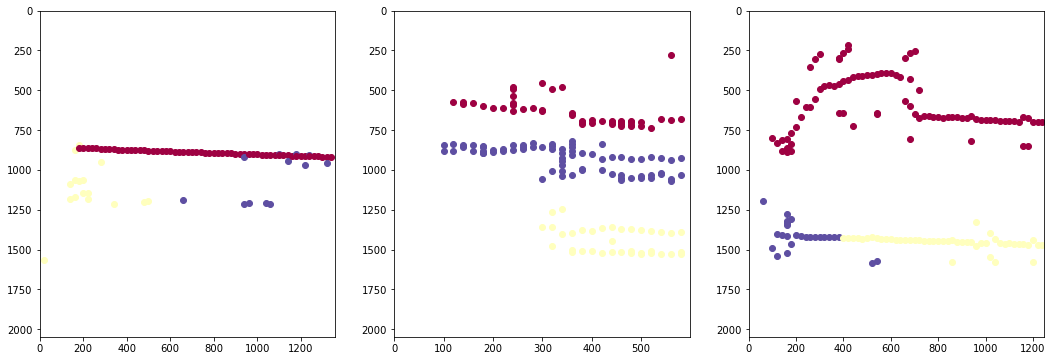

In [29]:
### Clustering those points by Gaussian Mixture to do linear fitting

data_labels = []
plt.figure(figsize=[18,6])
for i in range(0,3):
    plt.subplot(131+i)
#     clustering = DBSCAN(eps=100, min_samples=10, metric='euclidean', 
#                         metric_params=None, algorithm='auto', 
#                         leaf_size=30, p=None, n_jobs=None)
#     clustering = OPTICS(min_samples=20, xi=0.2)
    clustering = GaussianMixture(n_components=3) # n_components is the number of clusters
    X = np.array([[k,j] for k,j in zip(data[i][0], data[i][1])])
    labels = clustering.fit_predict(X)
    unique_labels = list(set(labels))
    data_labels.append(labels)
#     print(unique_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    cmap = {}
    for j in range(0,len(unique_labels)):
        cmap[unique_labels[j]] = colors[j]
#     print(cmap)
    for k in range(0,len(X)):
        plt.plot(X[k,0],X[k,1],marker='o',c=cmap[labels[k]])
    plt.ylim([0,pf[i].shape[0]])
    plt.xlim([0,pf[i].shape[1]])
    plt.gca().invert_yaxis()
    

0 0.04884278199883108 853.6082992402104 0.9982134333669737 1.8779728055323263e-71 0.0003872309852431182
1 -0.08149108589951377 1140.4836304700161 -0.06158894216109667 0.820745671850723 0.35295398834700287
2 -0.5017307692307692 1579.8461538461538 -0.6128667094724324 0.034102461380145076 0.20456635293097275
0 0.31895923922649977 516.9760313925125 0.43641508424839204 0.0024288396100637676 0.09913539797274587
1 0.36353516392369145 1279.6967739119048 0.380784374178733 0.021954583520059728 0.15139507031166247
2 0.37998501325750295 794.9968745596843 0.6608495260150168 2.6641864386689823e-10 0.05157939253209488
0 0.10097823416523934 526.6595461053273 0.186067073567706 0.08629408307889984 0.058179171874661664
1 0.07167285761776056 1392.8691025770738 0.41129357807403044 0.0036826090919748686 0.02341973330932414
2 0.39152208550942724 1324.6136584934054 0.5400716485430069 0.00532356643614739 0.1272203312077929
[['2.8'], ['20.81'], ['4.1']]


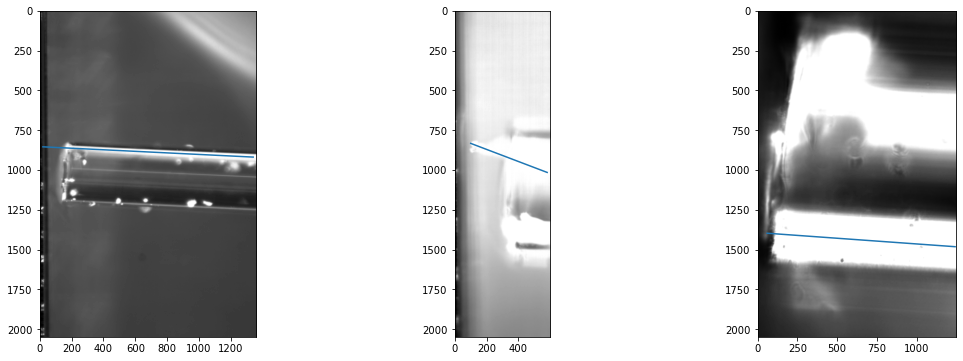

In [32]:
### Angle calculation: select lines with minimum std dev
### To fit robust? Neglect outliers?

plt.figure(figsize=[18,6])
degs = []
for i in range(0,3):
    X = np.array([[i,j] for i,j in zip(data[i][0], data[i][1])])
    min_std = 1.0
    max_r = 0.0
    for j in set(data_labels[i]):
        xy = X[data_labels[i] == j]
        if len(xy) > 5:
            slope, intercept, r_value, p_value, std_err = linregress(xy[:,0], xy[:,1]) # fiting a linear line
            print(j, slope, intercept, r_value, p_value, std_err)
            if (std_err <= min_std) & (r_value > 0):
                min_std = std_err
                max_r = r_value
                selected_label = j
                selected_slope = slope
                selected_intercept = intercept
    
    degs.append([np.format_float_positional(np.arctan(selected_slope)/np.pi*180, precision=2)])
    x_hat = np.linspace(X[:,0].min(), X[:,0].max(), 100) # to plot the orange line
    y_hat = selected_slope*x_hat+selected_intercept
    
    plt.subplot(131+i)
    plt.plot(x_hat, y_hat, '-')
    plt.imshow(f[i], cmap='gray')
print(degs)

Corner detection
- Harris
- Shi-tomasi
- SIFT
- FAST
- BRIEF
- ORB

[[[108.  35.]]

 [[108. 196.]]

 [[ 57. 180.]]

 [[  5.   5.]]

 [[ 28. 131.]]

 [[ 57. 127.]]

 [[108.   6.]]

 [[ 87.  73.]]

 [[  6. 207.]]

 [[ 25. 181.]]

 [[ 30. 161.]]

 [[ 39.  25.]]

 [[ 47. 164.]]

 [[ 29.  70.]]

 [[ 62. 164.]]

 [[ 75.  60.]]

 [[ 43.  50.]]]


/var/folders/08/x_z078yx20v88b8mc1v3xcv80000gn/T/ipykernel_18059/3579163994.py:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('234')
/var/folders/08/x_z078yx20v88b8mc1v3xcv80000gn/T/ipykernel_18059/3579163994.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('235')


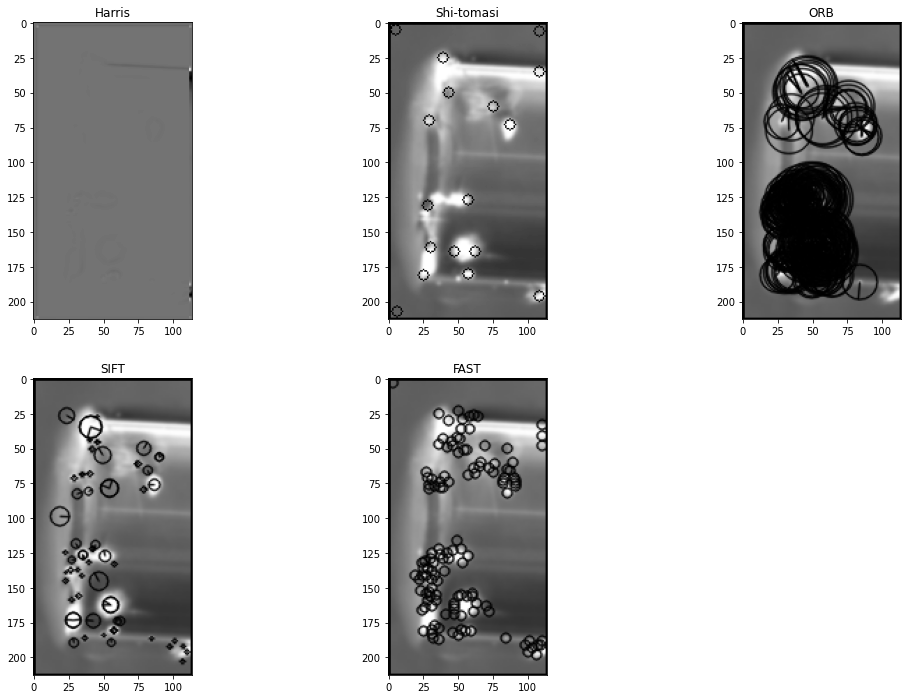

In [136]:
### Corner detections

plt.figure(figsize=[18,12])

### Harris
plt.subplot(231)
result = cv.cornerHarris(np.float32(sub_image), 2, 3, 0.04, cv.BORDER_DEFAULT)
plt.title('Harris')
plt.imshow(result, cmap='gray')

### Shi-tomasi
plt.subplot(232)
result = sub_image.copy()
feature_params = dict( maxCorners = 200,
                       qualityLevel = 0.1,
                       minDistance = 15,
                       blockSize = 9)
corners = cv.goodFeaturesToTrack(sub_image, **feature_params)
if corners is not None:
    for x, y in np.float32(corners).reshape(-1, 2):
        cv.circle(result, (int(x),int(y)), 4, (0, 0, 0), 1)
print(corners)
plt.title('Shi-tomasi')
plt.imshow(result, cmap='gray')

### ORB
plt.subplot(233)
orb = cv.ORB_create(nfeatures=200, scaleFactor=1.1, nlevels=8, edgeThreshold=25, firstLevel=0,
                    WTA_K=2, patchSize=25,fastThreshold=20)
kp = orb.detect(sub_image,None)
kp, des = orb.compute(sub_image, kp)
result = cv.drawKeypoints(sub_image, kp, None, color=(0,0,0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.title('ORB')
plt.imshow(result, cmap='gray')

### SIFT
plt.subplot('234')
sift = cv.SIFT_create()
kp = sift.detect(sub_image,None)
result=cv.drawKeypoints(sub_image, kp, None, color=(0,0,0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.title('SIFT')
plt.imshow(result, cmap='gray')

### FAST
plt.subplot('235')
fast = cv.FastFeatureDetector_create()
kp = fast.detect(sub_image,None)
result=cv.drawKeypoints(sub_image, kp, None, color=(0,0,0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.title('FAST')
plt.imshow(result, cmap='gray')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
463   352
(463, 352)
(349, 565)


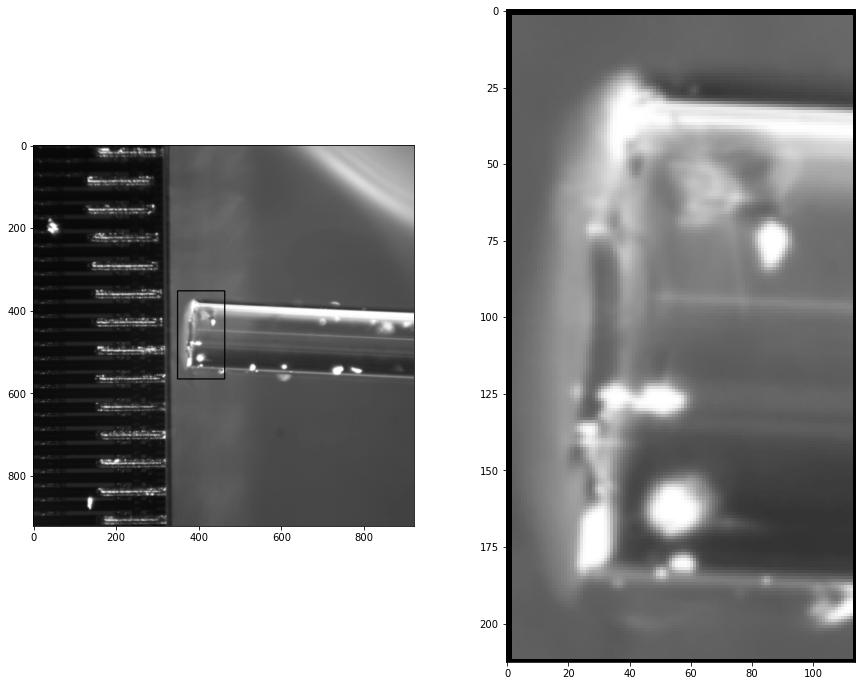

In [130]:
from img_processing import *
%load_ext autoreload
%autoreload ### Area of interest

## Input square
#New library
import argparse

img = rescale(blurs[0],0.45)

def click_event (event, x, y, flags, params):
    global coord, cropping  # array of arrays of coordinates for rectangle, indicate if cropping is taking place
    if event == cv.EVENT_LBUTTONDOWN: # detecting only left button event
        print (x, ' ', y) # printing coordinates
        coord =[(x,y)]
        cropping = True

    elif event == cv.EVENT_LBUTTONUP: # see if the left mouse if release
        coord.append((x,y))
        cropping = False

        #draw the rectangle in image
        cv.rectangle(img, coord[0], coord[1], (0,255,0), 2)
        cv.imshow('Area Selected', img) ## prints the image with the rectangle
        print(coord[0])
        print(coord[1])


cv.imshow('Click on pic',img) #if rescaling, you 
cv.setMouseCallback('Click on pic', click_event)
cv.waitKey(0)

x = coord[0][0]; y = coord[0][1]
w = coord[1][0]; h = coord[1][1] 
sub_image = img[y:h, w:x]

plt.figure(figsize=[15,12])
plt.subplot(121); plt.imshow(img, cmap='gray')
plt.subplot(122); plt.imshow(sub_image, cmap='gray')
plt.show()

In [4]:
from img_processing import *
%load_ext autoreload
%autoreload

Angle between chip edge and vertical line: 0.28
Angle between chip edge and fiber axis: 86.29
Minimum distance to chip edge: 91.20
Minimum distance to chip edge2: 103.01


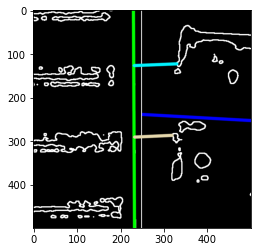

In [13]:
cropped, alpha1, alpha2, distancecorner, corners, distanceline, coord, otsuchip, otsufiber, contour_chip, contour_fiber = get_processed_array(img10, 
                                      vline=760, upper_hline=800, 
                                      lower_hline=1300, cluster_n_components = [4,5], binary = [True, True],
                                      threshold = [80, 200])
plt.imshow(cropped, cmap='gray')
print("Angle between chip edge and vertical line: " + alpha1)
print("Angle between chip edge and fiber axis: " + alpha2)
print("Minimum distance to chip edge: " + distancecorner)
print("Minimum distance to chip edge2: " + distanceline)

In [6]:
angled_line_fiber, line_params_fiber, X, labels, good_labels  = get_axial_line(contour_fiber[800:1300,:], 
        False, 'all', 20, 6)

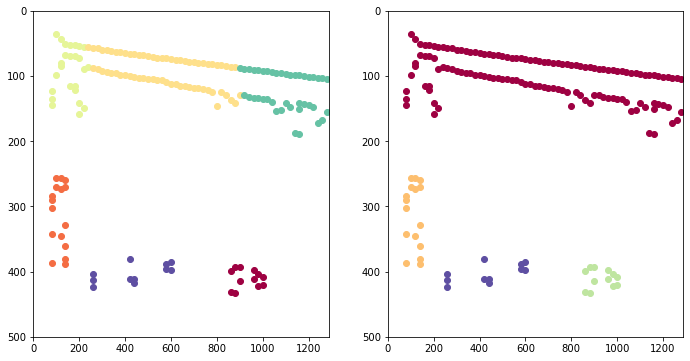

In [12]:
plt.figure(figsize=[18,6])
plt.subplot(131)
unique_labels = list(set(labels))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
cmap = {}
for j in range(0,len(unique_labels)):
    cmap[unique_labels[j]] = colors[j]
for k in range(0,len(X)):
    plt.plot(X[k,0],X[k,1],marker='o',c=cmap[labels[k]])
plt.ylim([0,contour_fiber[800:1300,:].shape[0]])
plt.xlim([0,contour_fiber[800:1300,:].shape[1]])
plt.gca().invert_yaxis()

plt.subplot(132)
clustering2 = DBSCAN(eps=100, min_samples=5, metric='euclidean', 
                    metric_params=None, algorithm='auto', 
                    leaf_size=30, p=None, n_jobs=None,)
labels2 = clustering2.fit_predict(X)
unique_labels2 = list(set(labels2))
colors2 = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels2))]
cmap2 = {}
for j in range(0,len(unique_labels2)):
    cmap2[unique_labels2[j]] = colors2[j]
for k in range(0,len(X)):
    plt.plot(X[k,0],X[k,1],marker='o',c=cmap2[labels2[k]])
plt.ylim([0,contour_fiber[800:1300,:].shape[0]])
plt.xlim([0,contour_fiber[800:1300,:].shape[1]])
plt.gca().invert_yaxis()

Angle between chip edge and vertical line: -0.67
Angle between chip edge and fiber axis: 76.97
Minimum distance to chip edge: 104.21
Coord of closest corner to chip: [1553.  260.]


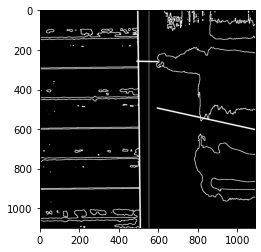

In [273]:
processed, alpha1, alpha2, distance, corners = get_processed_array(img20, vline=1510, upper_hline=1700, 
                                      lower_hline=600, cluster_n_components = [2,6])
plt.imshow(processed, cmap='gray')
print("Angle between chip edge and vertical line: " + alpha1)
print("Angle between chip edge and fiber axis: " + alpha2)
print("Minimum distance to chip edge: " + distance)
print("Coord of closest corner to chip: " + str(corners))

Angle between chip edge and vertical line: -0.07
Angle between chip edge and fiber axis: 86.35
Minimum distance to chip edge: 292.02
Coord of closest corner to chip: [ 883. 1509.]


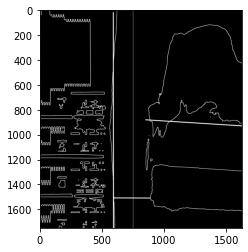

In [275]:
processed, alpha1, alpha2, distance, corners = get_processed_array(img50, vline=750, upper_hline=1750, 
                                      lower_hline=0, cluster_n_components = [1,8])
plt.imshow(processed, cmap='gray')
print("Angle between chip edge and vertical line: " + alpha1)
print("Angle between chip edge and fiber axis: " + alpha2)
print("Minimum distance to chip edge: " + distance)
print("Coord of closest corner to chip: " + str(corners))

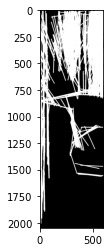

In [165]:
### Line detection: doesn't work well

rho = 10  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 100  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 200  # minimum number of pixels making up a line
max_line_gap = 100  # maximum gap in pixels between connectable line segments
line_image = np.copy(cannys[1]) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv.HoughLinesP(cannys[1], rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv.line(line_image,(x1,y1),(x2,y2),(255,255,255),5)

# Draw the lines on the  image
# lines_edges = cv.addWeighted(cannys[2], 0.8, line_image, 1, 0)
        
plt.imshow(line_image, cmap='gray')

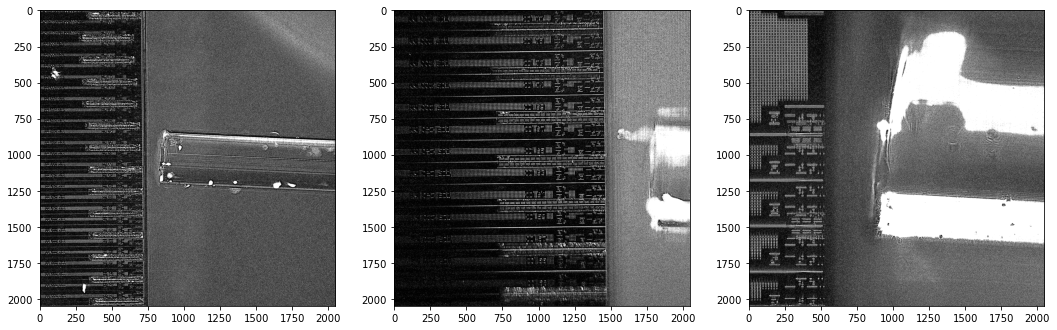

In [266]:
### Sharpening, look good but create too much noise in the background
plt.figure(figsize=[18,6])
sharpens = []
for i in range(0,3):
    sharpens.append(unsharp_mask(grays[i]))
    plt.subplot(131+i)
    plt.imshow(sharpens[i], cmap='gray')

Old codes on MOSFET image

(-5.0, 260.0)

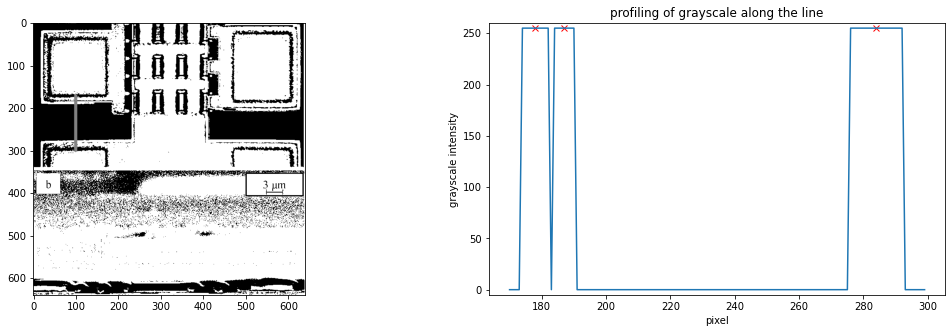

In [116]:
imageLine3 = gray_thresh_gbl.copy()

# The line starts from (200,100) and ends at (400,100)
# The color of the line is YELLOW (Recall that OpenCV uses BGR format)
# Thickness of line is 5px
# Linetype is cv2.LINE_AA

cv.line(imageLine3, (100, 170), (100, 300), (130, 130, 130), thickness=5, lineType=cv.LINE_AA);

plt.figure(figsize=[18,5])
# Display the image
plt.subplot(121); plt.imshow(imageLine3, cmap='gray')
#profiling
plt.subplot(122)
peaks3, properties3 = find_peaks(gray_thresh_gbl[170:300,100], prominence=3)
plt.plot(170+peaks3, gray_thresh_gbl[170:300,100][peaks3], "x", c="red")
plt.plot(range(170,300), gray_thresh_gbl[170:300,100])
# plt.axvline(x=189, c='green', ls='--')
# plt.axvline(x=278, c='green', ls='--')
plt.title('profiling of grayscale along the line')
plt.ylabel('grayscale intensity')
plt.xlabel('pixel')
plt.ylim([-5,260])

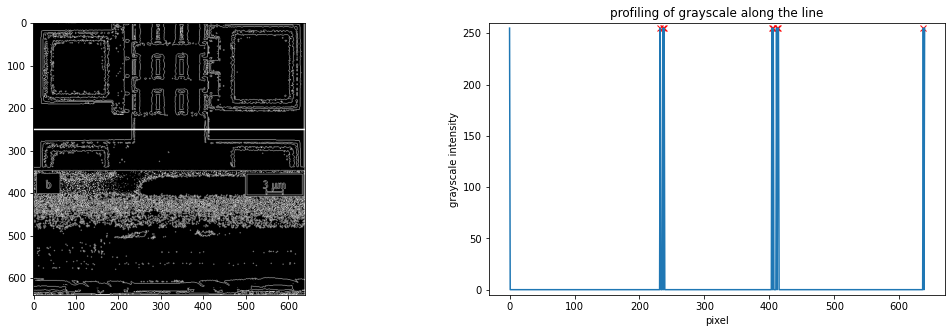

In [174]:
blank = np.zeros(gray.shape[:2], dtype = 'uint8')
contours, hierarchies = cv.findContours(gray_thresh_gbl, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(blank, contours, -1, (255,255,255), 1)
plt.figure(figsize=[18,5])
# Display the image
imageLine4 = blank.copy()
cv.line(imageLine4, (0, 250), (640, 250), (255, 255, 255), thickness=2, lineType=cv.LINE_AA)
plt.subplot(121); plt.imshow(imageLine4, cmap='gray')
#profiling
plt.subplot(122)
peaks4, properties4 = find_peaks(blank[250,0:640], prominence=3)
plt.plot(peaks4, blank[250,0:640][peaks4], "x", c="red")
plt.plot(range(0,640), blank[250,0:640])
# plt.axvline(x=189, c='green', ls='--')
# plt.axvline(x=278, c='green', ls='--')
plt.title('profiling of grayscale along the line')
plt.ylabel('grayscale intensity')
plt.xlabel('pixel')
plt.ylim([-5,260])
plt.show()

(-5.0, 260.0)

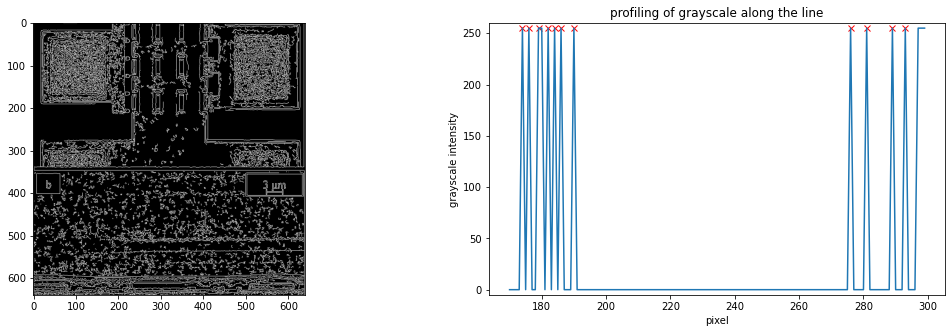

In [154]:
canny = cv.Canny(gray, 50, 100)
plt.figure(figsize=[18,5])
# Display the image
plt.subplot(121); plt.imshow(canny, cmap='gray')
#profiling
plt.subplot(122)
peaks5, properties5 = find_peaks(canny[170:300,100], prominence=1)
plt.plot(170+peaks5, canny[170:300,100][peaks5], "x", c="red")
plt.plot(range(170,300), canny[170:300,100])
plt.title('profiling of grayscale along the line')
plt.ylabel('grayscale intensity')
plt.xlabel('pixel')
plt.ylim([-5,260])